In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [2]:
craig = pd.read_csv('craig.csv')
craig.head()

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,...,county_fips,county_name,state_fips,state_code,state_name,weather,inf_model,lat_short,long_short,inf_state_code
0,marshall,11900,2010.0,dodge,challengerse,good,6 cylinders,gas,43600.0,clean,...,46083.0,Lincoln,46.0,SD,South Dakota,38.0,challenger,43.48,-96.70,MN
1,marshall,1515,1999.0,NaN,fleetwood,NaN,NaN,gas,NaN,clean,...,46039.0,Deuel,46.0,SD,South Dakota,38.0,fleetwood,44.76,-96.69,MN
2,marshall,17550,2008.0,ford,f150,NaN,NaN,gas,NaN,clean,...,46093.0,Meade,46.0,SD,South Dakota,38.0,f150,44.14,-103.21,MN
3,marshall,2800,2004.0,ford,taurus,good,6 cylinders,gas,168591.0,clean,...,19143.0,Osceola,19.0,IA,Iowa,47.0,taurus,43.28,-95.59,MN
4,marshall,400,2001.0,NaN,2001grandprix,NaN,NaN,gas,217000.0,clean,...,19109.0,Kossuth,19.0,IA,Iowa,47.0,grandprix,43.03,-94.41,MN


In [19]:
sns.set(style='white', rc={'figure.figsize':(12,6)})

## Feature Engineering

In [3]:
mask = (
    (craig.price > 1) &
    (craig.price <= 200000) |
    (craig.manufacturer == 'ferrari') |
    (craig.manufacturer == 'aston-martin')
)
craig_clean = craig.loc[mask]

In [15]:
mask = (
    (craig_clean.manufacturer == 'ferrari') |
    (craig_clean.manufacturer == 'aston-martin') | 
    (craig_clean.manufacturer == 'noble') | 
    (craig_clean.manufacturer == 'hennessey') 
)
craig_clean.loc[:, 'is_supercar'] = 0
craig_clean.loc[mask, 'is_supercar'] = 1

mask = (
    (craig_clean.paint_color == 'brown') | 
    (craig_clean.paint_color == 'purple') | 
    (craig_clean.paint_color == 'green') 
)
craig_clean.loc[:, 'gross_color'] = 0
craig_clean.loc[mask, 'gross_color'] = 1

mask = (
    (craig_clean.type == 'truck') |
    (craig_clean.type == 'pickup')
)
craig_clean.loc[:, 'is_truck'] = 0
craig_clean.loc[mask, 'is_truck'] = 1

mask = (
    (craig_clean.state_code == 'HI') |
    (craig_clean.state_code == 'WA') | 
    (craig_clean.state_code == 'AK')
)
craig_clean.loc[:, 'pricey_state'] = 0
craig_clean.loc[mask, 'pricey_state'] = 1

mask = (
    (craig_clean.transmission == 'automatic') &
    (craig_clean.drive == 'fwd')
)
craig_clean.loc[:, 'is_auto_fwd'] = 0
craig_clean.loc[mask, 'is_auto_fwd'] = 1

#needed to create this variable even though it exists in the condition column
#there is a lot of bad data there with very old cars being classified as new
mask = (
    (craig_clean.year >= 2018) &
    (craig_clean.odometer < 300)
)
craig_clean.loc[:, 'is_new'] = 0
craig_clean.loc[mask, 'is_new'] = 1

mask = (
    (craig_clean.inf_model == 'f250') & 
    (craig_clean.state_code == 'NC') |
    (craig_clean.state_code == 'TX') |
    (craig_clean.state_code == 'AL') |
    (craig_clean.state_code == 'MD') |
    (craig_clean.state_code == 'OK') |
    (craig_clean.state_code == 'NE')
)
craig_clean.loc[:, 'f250_pricey_state'] = 0
craig_clean.loc[mask, 'f250_pricey_state'] = 1

mask = (
    (craig_clean.inf_model == 'mustang') & 
    (craig_clean.state_code == 'MT') |
    (craig_clean.state_code == 'MN') |
    (craig_clean.state_code == 'ME') |
    (craig_clean.state_code == 'CO')
)
craig_clean.loc[:, 'stang_pricey_state'] = 0    
craig_clean.loc[mask, 'stang_pricey_state'] = 1

mask = (
    (craig_clean.make == 'spider') |
    (craig_clean.make == 'porsche911') |
    (craig_clean.make == 'fpace') |
    (craig_clean.make == 'giulia') |
    (craig_clean.make == 'qx80') |
    (craig_clean.make == 'qx460') |
    (craig_clean.make == 'f650') |
    (craig_clean.make == 'peterbilt') |
    (craig_clean.make == 'evoque') |
    (craig_clean.make == 'qx60')
)
craig_clean.loc[:, 'pricey_model'] = 0    
craig_clean.loc[mask, 'pricey_model'] = 1

craig_clean.loc[:, 'is_canadian'] = 0
craig_clean.loc[craig_clean.state_code == 'CAN', 'is_canadian'] = 1

mask = (
    (craig_clean.type == 'coupe') &
    (craig_clean.paint_color == 'orange') |
    (craig_clean.paint_color == 'yellow')
)
craig_clean.loc[:, 'is_hot_coupe'] = 0
craig_clean.loc[mask, 'is_hot_coupe'] = 1

mask = (
    (craig_clean.type == 'convertible') &
    (craig_clean.paint_color == 'orange') |
    (craig_clean.paint_color == 'yellow') |
    (craig_clean.paint_color == 'custom') |
    (craig_clean.paint_color == 'purple')
)
craig_clean.loc[:, 'is_hot_convertible'] = 0
craig_clean.loc[mask, 'is_hot_convertible'] = 1

craig_clean['vehicle_age'] = 2019 - craig_clean.year

In [5]:
#****need to keep pd.concat of dummy columns separate and ONLY RUN ONCE****
fullsize = pd.get_dummies(craig_clean['size'], prefix='car_size')
craig_clean = pd.concat([craig_clean, fullsize], axis=1)

In [23]:
#need to binarize the price column for this challenge
#bi_price == 1 will be greater than the median
median = craig_clean.price.median()
craig_clean['bi_price'] = np.where(craig_clean.price > median, 1, 0)
craig_clean.groupby('bi_price')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bi_price,,,,,,,,
0,853851.0,3510.506700,1930.603491,1.0,1900.0,3495.0,5000.0,7200.0
1,849590.0,18646.116009,12944.507780,7201.0,10500.0,15000.0,22990.0,3450000.0


In [26]:
model_df = craig_clean.loc[:,['bi_price',
                              'odometer',
                              'vehicle_age',
                              'is_supercar',
                              'is_truck',
                              'gross_color',
                              'car_size_full-size',
                              'is_auto_fwd',
                              'is_new',
                              'f250_pricey_state',
                              'stang_pricey_state',
                              'pricey_model',
                              'pricey_state',
                              'is_canadian',
                              'is_hot_coupe',
                              'is_hot_convertible',
                              'long',
                              'lat'
                             ]]
#null_df = model_df.isnull().any() 
#print(null_df[null_df == True])

#This is still needed because there are nulls in 'vehicle_age' and 'odometer'
#Those are the next columns to be cleaned in my TODO list for next challenge
model_df.dropna(inplace=True)
model_df.head()

,bi_price,odometer,vehicle_age,is_supercar,is_truck,gross_color,car_size_full-size,is_auto_fwd,is_new,f250_pricey_state,stang_pricey_state,pricey_model,pricey_state,is_canadian,is_hot_coupe,is_hot_convertible,long,lat
0,1,43600.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,-96.704100,43.477500
3,0,168591.0,15.0,0,0,0,1,1,0,0,0,0,0,0,0,0,-95.593000,43.284500
4,0,217000.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,0,-94.406400,43.026100
5,1,169000.0,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,-96.774445,43.328149
6,1,39500.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,-96.633200,43.548600


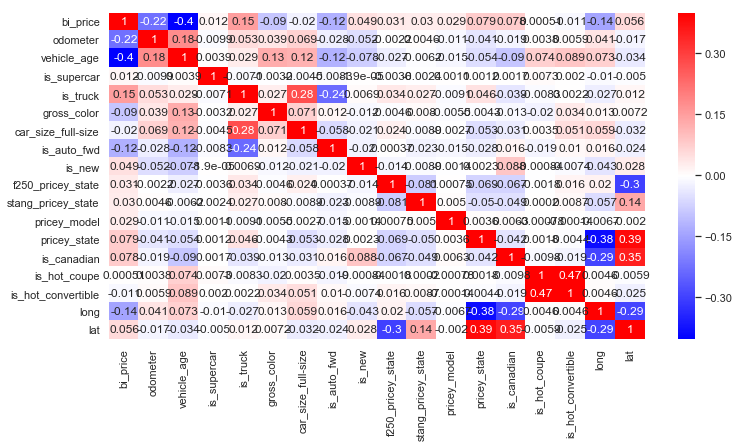

In [27]:
plt.figure(figsize=(12,6))
sns.heatmap(model_df.corr(), cmap='bwr', center=0, annot=True, vmax=0.4)
plt.show()

In [28]:
#train/test split
Y = model_df['bi_price']
X = model_df.drop(['bi_price'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 38)

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in test: {}'.format(len(X_test)))

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

The number of observations in training: 917232
The number of observations in test: 229308


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


## Vanilla Logistic Regression

In [46]:
#BayesSearchCV to determine hyperparameters
lr = LogisticRegression()

params = {
    'solver':Categorical(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'fit_intercept':Categorical([True, False]),
    'C':Real(0.01, 1e24, prior='uniform')
}

opt = BayesSearchCV(
    lr,
    params,
    cv=5,
    n_iter=5,
    random_state=87265
)

opt.fit(X_train, Y_train)

#print the hyperparameters in order to use for logistic regression in next cell
print('Bayesian Search CV parameters: {}'.format(opt.best_params_))

/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search fail

Bayesian Search CV parameters: {'C': 6.944853792722985e+23, 'fit_intercept': True, 'solver': 'saga'}


In [54]:
lr = LogisticRegression(C=2.7e23, fit_intercept=True, solver='saga')
lr.fit(X_train, Y_train)
Y_train_pred = lr.predict(X_train)
Y_test_pred = lr.predict(X_test)
print('****    Training Statistics    ****')
print('R^2:', lr.score(X_train, Y_train))
print('AUROC score:', roc_auc_score(Y_train, Y_train_pred))
print('Precision, Recall, f1_score, support')
print(precision_recall_fscore_support(Y_train, Y_train_pred, average='binary', pos_label=1))

print('\n\n****    Test Statistics    ****')
print('R^2:', lr.score(X_test, Y_test))
print('AUROC score:', roc_auc_score(Y_test, Y_test_pred))
print('Precision, Recall, f1_score, support')
print(precision_recall_fscore_support(Y_test, Y_test_pred, average='binary', pos_label=1))

****    Training Statistics    ****
R^2: 0.7982942156400997
AUC score: 0.7899503336388656
Precision, Recall, f1_score, support
(0.8099273211401633, 0.8468935009708701, 0.8279980253487946, None)


****    Test Statistics    ****
R^2: 0.7976738709508608
AUC score: 0.7891769181744991
Precision, Recall, f1_score, support
(0.8089987215248722, 0.847106966555362, 0.8276143942631021, None)


For general logistic regression, the precision and recall are both pretty good. The model does a better job at predicting the positives than the negatives. This makes sense considering most of the engineered features are positively correlated with price and should be reflective of cars priced over the median. The generalization gap between training and test is actually quite small at 0.001 and the Precision, Recall, and f1_score are all positive.

## Ridge Regression

In [77]:
#BayesSearchCV to determine hyperparameters
rregr = Ridge()

params = {
    'alpha':Real(0.01, 1e24, prior='uniform'),
    'solver':Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'fit_intercept':Categorical([True, False])
}

opt = BayesSearchCV(
    rregr,
    params,
    cv=5,
    n_iter=10,
    random_state=87265
)

opt.fit(X_train, Y_train)

#print the hyperparameters in order to use for logistic regression in next cell
print('Bayesian Search CV parameters: {}'.format(opt.best_params_))

Bayesian Search CV parameters: {'alpha': 2.766912407053618e+23, 'fit_intercept': True, 'solver': 'saga'}


In [78]:
rregr = Ridge(alpha=2.7e23, fit_intercept=True, solver='saga')
rregr.fit(X_train, Y_train)
print('Coefficients:\n', rregr.coef_)
Y_train_pred = rclass.predict(X_train)
Y_test_pred = rclass.predict(X_test)
print('\n****    Training Statistics    ****')
print('R^2:', rclass.score(X_train, Y_train))
print('AUROC score:', roc_auc_score(Y_train, Y_train_pred))

print('\n\n****    Test Statistics    ****')
print('R^2:', rclass.score(X_test, Y_test))
print('AUROC score:', roc_auc_score(Y_test, Y_test_pred))

Coefficients:
 [-3.74671266e-19 -6.75851156e-19  1.92920067e-20  2.55640132e-19
 -1.50661558e-19 -3.33695186e-20 -2.08812274e-19  8.26162442e-20
  5.27247023e-20  5.12774378e-20  4.91396097e-20  1.32961688e-19
  1.31508596e-19  1.10083838e-21 -1.74520252e-20 -2.40177438e-19
  9.38128137e-20]

****    Training Statistics    ****
R^2: 0.7751234147958205
AUC score: 0.7813262499386616


****    Test Statistics    ****
R^2: 0.7737584384321524
AUC score: 0.7799710354946925


Ridge classification performs slightly worst than vanilla logistic regression when it comes to predicting whether the price of a car is greater than the median or not. The AUC score is still showing that its better than a coin flip. Using regular Ridge regression instead of classification made these results hard to analyze. It would be better to be able to understand how effective our model is at predicting the classifier. It is interesting that the Bayesian Search CV tool resulted in very similar hyperparameters for both logistic regression and ridge regression.

## Lasso Regression

In [70]:
#BayesSearchCV to determine hyperparameters
lsr = Lasso()

params = {
    'alpha':Real(0.00001, 0.001, prior='uniform'),
    'fit_intercept':Categorical([True, False])
}

opt = BayesSearchCV(
    lsr,
    params,
    cv=5,
    n_iter=10,
    random_state=87265
)

opt.fit(X_train, Y_train)

#print the hyperparameters in order to use for logistic regression in next cell
print('Bayesian Search CV parameters: {}'.format(opt.best_params_))

Bayesian Search CV parameters: {'alpha': 0.00028392432829830826, 'fit_intercept': True}


In [82]:
lsr = Lasso(alpha=0.00028, fit_intercept=True)
lsr.fit(X_train, Y_train)
print('Coefficients:\n', lsr.coef_)
Y_train_pred = lsr.predict(X_train)
Y_test_pred = lsr.predict(X_test)
print('\n****    Training Statistics    ****')
print('R^2:', lsr.score(X_train, Y_train))
print('AUROC score:', roc_auc_score(Y_train, Y_train_pred))


print('\n\n****    Test Statistics    ****')
print('R^2:', lsr.score(X_test, Y_test))
print('AUROC score:', roc_auc_score(Y_test, Y_test_pred))

Coefficients:
 [-0.07877504 -0.18883752  0.00477881  0.06761961 -0.01707784 -0.00038581
 -0.06879399  0.00062095  0.01031568  0.00987761  0.00951682  0.00516773
  0.01210035  0.0092156   0.00906401 -0.04419842  0.        ]

****    Training Statistics    ****
R^2: 0.2482330105192604
AUROC score: 0.8632722828408501


****    Test Statistics    ****
R^2: 0.24713767330230516
AUROC score: 0.8629857694730254


Lasso regression as a feature selection tool did take one of the features coefficients to 0. The AUROC score did increase in this model compared to both Ridge and Logistic regression, which could mean that it is doing a better job of predicting whether the price is above the median. Considering we are using regression to predict a classifier, the R^2 value decreasing to 0.24 is not surprising and not being considered for model selection here. 

## Conclusions and Model Selection

I think the logistic regression model performed the best out of the three options above. The models performance was better than Ridge and potentially the Lasso model (more on that in a minute). There was also a high degree of interpretability present with the model.

Ridge regression performed slightly worse from an R^2 and AUROC perspective and it lost interpretability by not being able to calculate precision, recall, or f1. This wouldn't be my choice for this application.

Lasso regression performed much worse from an R^2 perspective, but the AUROC score was much higher which might indicate that it is doing a better job of prediction. Also, it did drop one feature which made the model simpler. However, without a classification component the interpretability of performance and the results make this a poor choice for this application.

The logistic regression model had the right balance of performance and interpretability for predicting car prices that are over the median. 